In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Ensembles, Random Forest
**Author**: Maria Tikhonova



In [2]:
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.datasets import fetch_california_housing
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz
import pydotplus

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


# Increase viewable area of Pandas tables, numpy arrays, plots
pd.set_option('display.max_rows', 15, 'display.max_columns', 500, 'display.max_colwidth', 1, 'display.precision', 2)
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
sns.set()
plt.rcParams['figure.figsize'] = [16, 6]

# 1. Bias-Variance Decomposition

Рассмотрим задачу регрессией с MSE ошибкой. Предположим, что исходная зависимость выражается следующим образом:
$$ 
y(x) = f(x) + \epsilon 
$$ 

где $ \epsilon $ гауссовский шум, $\epsilon \sim \mathcal{N}(0,\sigma^2) $. 

Обозначим предсказания регрессионной модели как $ a(x) = \hat{y} $. 
Тогда для математического ожидания ошибки имеем следующее соотношение:

\begin{equation}
\begin{split}
Error & = \mathbb{E}_{X,Y,\epsilon}\left[(a(x) - y(x))^2\right] = \\
      & = \mathbb{E}_{X,Y}\left[(a(x) - \mathbb{E}_{X,Y}[a(x)])^2\right]  + \left(\mathbb{E}_{X,Y}\left[a(x)\right] - f(x)\right)^2 +  \sigma^2 = \\ & = \text{Variance} + \text{Bias}^2  + \text{Noise}
\end{split}
\end{equation}

Компоненты ошибки могут быть интерпретированы как:
* $\text{Variance}$ (Разброс) - чувствительность модели к данным. Высокая дисперсия обычно означает, что модель переобучилась.
* $\text{Bias}$ (Смещение) - отвечает за точность модели. Высокое смещение обычно означает, что модель недообучилась (underfitted).
* $\text{Noise}$ (Шум) - шум в данных (can't be helped).

## Пример

Для примера рассмотрим задачу регрессии и модель kNN.

### Одна модель

In [3]:
# Define target function for regression
def f(x):
    return np.sin(x)

Сгенерируем train и test.

In [21]:
# Define noise level
sigma = 0.2

# Generate train sample
X_train = np.random.random(size=5) * 2 * np.pi
y_train = f(X_train) + np.random.normal(loc=0., scale=sigma, size=len(X_train))

# Generate test smaple
X_test = np.linspace(0, 2*np.pi, 1000)
y_test = f(X_test) + np.random.normal(loc=0., scale=sigma, size=len(X_test))

In [22]:
X_train

array([1.3289, 6.1602, 3.7288, 2.5309, 3.2728])

Обучим регрессионную модель.

In [23]:
from sklearn.neighbors import KNeighborsRegressor

# Create a model
reg = KNeighborsRegressor(n_neighbors=1)

# Fit the model
reg.fit(X_train.reshape(-1, 1), y_train)

KNeighborsRegressor(n_neighbors=1)

Сделаем предсказания для тестового сета.

In [24]:
from sklearn.metrics import mean_squared_error

# Make predictions
y_test_predict = reg.predict(X_test.reshape(-1, 1))

Визуализируем результат.

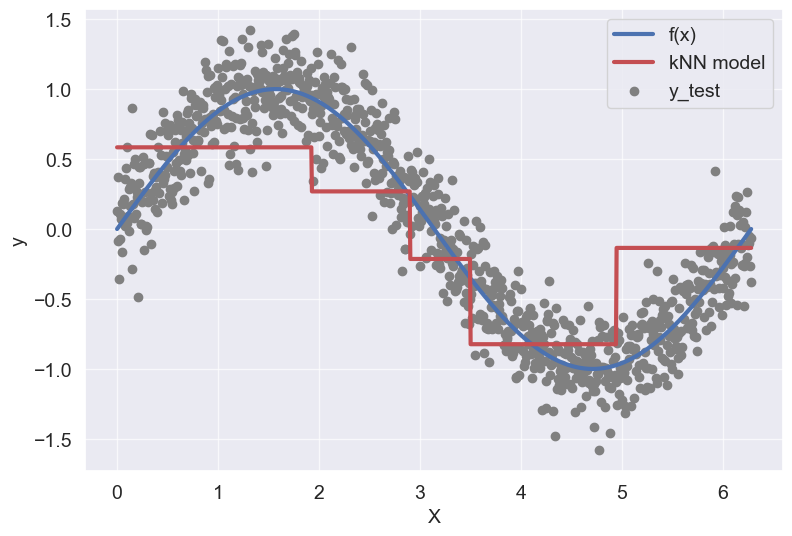

In [25]:
plt.figure(figsize=(9, 6))

plt.plot(X_test, f(X_test), label='f(x)', color='b', linewidth=3)
plt.plot(X_test, y_test_predict, label='kNN model', color='r', linewidth=3)
plt.scatter(X_test, y_test, label='y_test', color='0.5')

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("y", size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(alpha = 0.7)
plt.show()

Визуализируем ошибку модели.

In [26]:
errors = (y_test_predict - y_test)**2

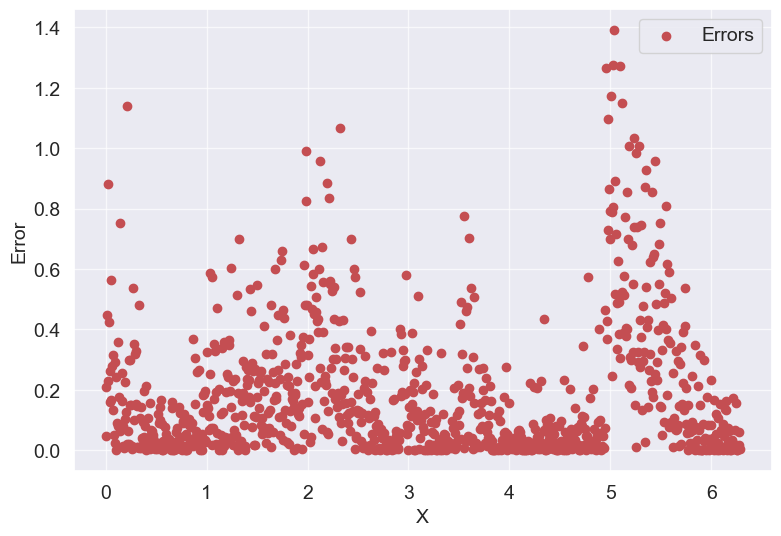

In [27]:
plt.figure(figsize=(9, 6))

plt.scatter(X_test, errors, label='Errors', color='r')

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("Error", size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(alpha = 0.7)
plt.show()

## Несколько моделей

Обучим несколько моделей на рандомных обучающих сэмплах.

In [28]:
# Define noise level
sigma = 0.2

# Generate train sample
X_train = np.random.random(size=5) * 2 * np.pi
y_train = f(X_train) + np.random.normal(loc=0., scale=sigma, size=len(X_train))

# Generate test smaple
X_test = np.linspace(0, 2*np.pi, 1000)
y_test = f(X_test) + np.random.normal(loc=0., scale=sigma, size=len(X_test))

In [33]:
N_iter = 10000
predictions = []
errors = []

for i in range(N_iter):
    
    # Generate random train sample
    X_train = np.random.random(size=5) * 2 * np.pi
    y_train = f(X_train) + np.random.normal(loc=0., scale=sigma, size=len(X_train))
    
    # Create a model
    reg = KNeighborsRegressor(n_neighbors=1)
    
    # Fit the model
    reg.fit(X_train.reshape(-1, 1), y_train)
    
    # Make predictions
    y_test_predict = reg.predict(X_test.reshape(-1, 1))
    
    # Save predictions
    predictions.append(y_test_predict)
        
    # Generate random test y
    y_test_iter = f(X_test) + np.random.normal(loc=0., scale=sigma, size=len(X_test))

    # Calculate errors
    errors_iter = (y_test_predict - y_test_iter)**2

    # Save errors
    errors.append(errors_iter)
    
predictions = np.array(predictions)
errors = np.array(errors)

Оценим матожидание предсказаний.

In [34]:
y_test_predict_mean = predictions.mean(axis=0)

Визуализируем модели.

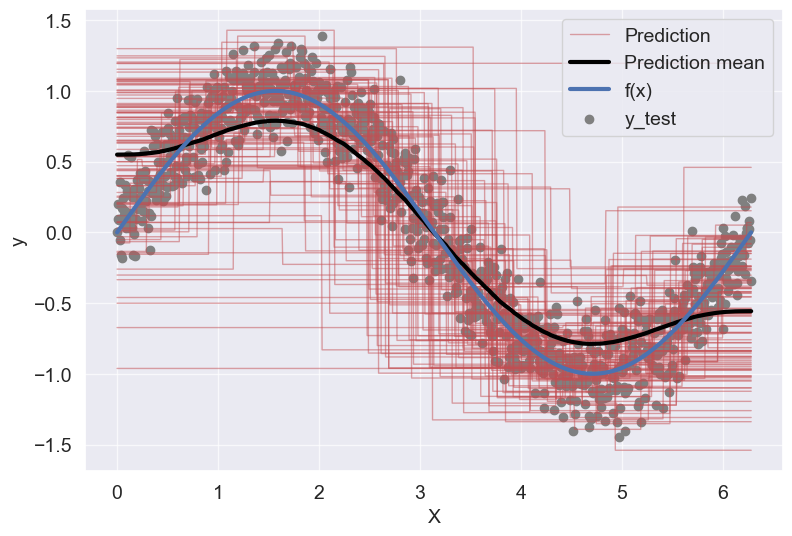

In [35]:
plt.figure(figsize=(9, 6))

for y_test_predict in predictions[:100]:
    plt.plot(X_test, y_test_predict, color='r', linewidth=1, alpha=0.5)

plt.plot(X_test, predictions[0], label='Prediction', color='r', linewidth=1, alpha=0.5)
plt.plot(X_test, y_test_predict_mean, label='Prediction mean', color='0', linewidth=3)
plt.plot(X_test, f(X_test), label='f(x)', color='b', linewidth=3)
plt.scatter(X_test, y_test, label='y_test', color='0.5')

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("y", size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(alpha = 0.7)
plt.show()

### Разложение

\begin{equation}
\begin{split}
Error & = \mathbb{E}_{X,Y,\epsilon}\left[(a(x) - y(x))^2\right] = \\
      & = \mathbb{E}_{X,Y}\left[(a(x) - \mathbb{E}_{X,Y}[a(x)])^2\right]  + \left(\mathbb{E}_{X,Y}\left[a(x)\right] - f(x)\right)^2 +  \sigma^2 = \\ & = \text{Variance} + \text{Bias}^2  + \text{Noise}
\end{split}
\end{equation}

In [36]:
# Calculate expected errors
error = errors.mean(axis=0)

# Calculate varince of the model predictions
variance = predictions.std(axis=0)**2

# Calculate the model's bias
bias2 = (y_test_predict_mean - f(X_test))**2

# Calculate the noise variance
noise = sigma**2

composition = variance + bias2 + noise

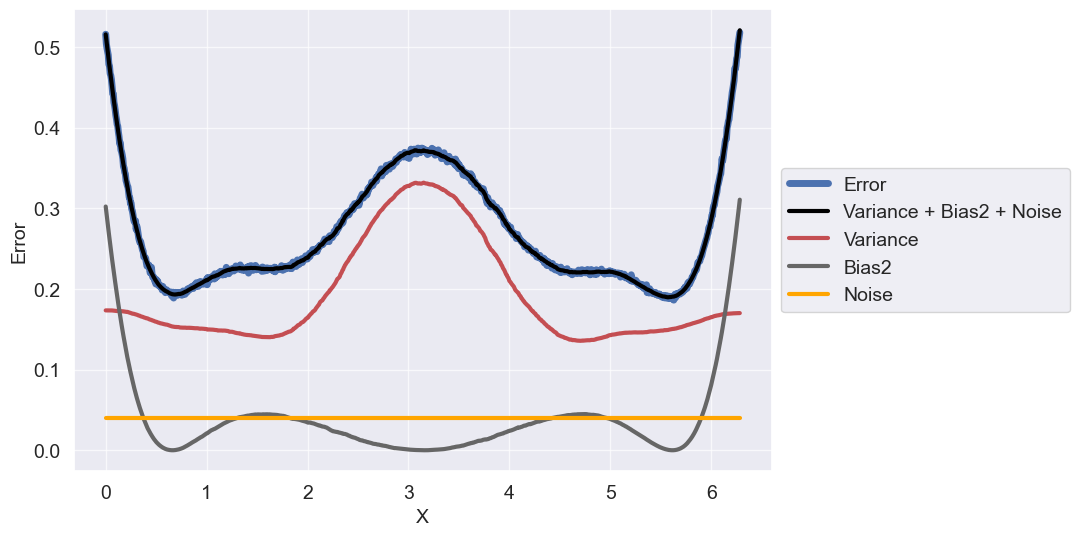

In [37]:
plt.figure(figsize=(9, 6))

plt.plot(X_test, error, label='Error', color='b', linewidth=5)
plt.plot(X_test, composition, label='Variance + Bias2 + Noise', color='0', linewidth=3)
plt.plot(X_test, variance, label='Variance', color='r', linewidth=3)
plt.plot(X_test, bias2, label='Bias2', color='0.4', linewidth=3)
plt.plot(X_test, [noise]*len(X_test), label='Noise', color='orange', linewidth=3)

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("Error", size=14)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(alpha = 0.7)
plt.show()

## Bonus part on theory
**Attention!**  Достаточно сложный теоретический [материал](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem08-bvd.pdf) по bias-variance decomposition.



# 2. Ансамбли

### Data  - Titanic data set

Сегодня будем работать с данными о пассажирах Титаника (Titatic dataset).

In [4]:
#data = pd.read_csv('titanic.csv')
data = pd.read_csv('https://grantmlong.com/data/titanic.csv')
cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
data = data.drop(cols_2_drop, axis=1)
data.loc[:, 'Age'] = data.Age.fillna(-999)

data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.25,S
1,1,1,female,38.0,1,0,71.28,C
2,1,3,female,26.0,0,0,7.92,S
3,1,1,female,35.0,1,0,53.10,S
4,0,3,male,35.0,0,0,8.05,S


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


Пропусков в данных нет, мы их уже заполнили, но есть 2 категориальных признака (`Sex`,`Embarked`). Закодируем их с помощью `OrdinalEncoder`.

В `sklearn` есть две похожие функции `LabelEncoder` и `OriginalEncoder`. `LabelEncoder` кодирует один столбец и как правило применяется для кодирования целевой переменной, тогда как `OriginalEncoder` может принимать на вход несколько столбцов сразу и используется для кодирования матрицы признаков.

In [6]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(min_frequency=1)
data[['Sex','Embarked']] = enc.fit_transform(data[['Sex','Embarked']]).astype(int)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.25,2
1,1,1,0,38.0,1,0,71.28,0
2,1,3,0,26.0,0,0,7.92,2
3,1,1,0,35.0,1,0,53.10,2
4,0,3,1,35.0,0,0,8.05,2


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    int64  
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 62.5 KB


In [8]:
X = data.drop('Survived', axis=1)
Y = data['Survived']

## Recap: высокий разброс решающих деревьев

Деревья решений обладают **высоким разбросом (high variance)**. Небольшие колебания в данных могут привести к сильным измениниям в получившихся обученных деревьях. 

Сравним деревья с разным random_state (в нашем случае 2 и 7). Получим разную точность работы алгоритмов.

In [9]:
def plot_tree(model, X, fname='temp_tree.png'):
    dot_data = export_graphviz(model, filled=True, rounded=True, feature_names=X.columns, out_file=None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

In [10]:
# Random state affects the order at which predictors are considered. At each split the predictors are randomly permuted
#Train test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

tree1 = DecisionTreeClassifier(random_state=2, max_depth=3)
tree1.fit(train_X, train_Y)
tree1_r2 = r2_score(tree1.predict(test_X), test_Y)
tree1_accuracy = accuracy_score(tree1.predict(test_X), test_Y)
print(f'Accuracy for the first tree: {tree1_accuracy:.4f}')

train_X_2, test_X_2, train_Y_2, test_Y_2 =train_test_split(X, Y, test_size=0.2, random_state=7)

tree2 = DecisionTreeClassifier(random_state=7, max_depth=3)
tree2.fit(train_X_2, train_Y_2)

tree2_accuracy = accuracy_score(tree2.predict(test_X_2), test_Y_2)

print(f'Accuracy for the second tree: {tree2_accuracy:.4f}')

Accuracy for the first tree: 0.7753
Accuracy for the second tree: 0.7978


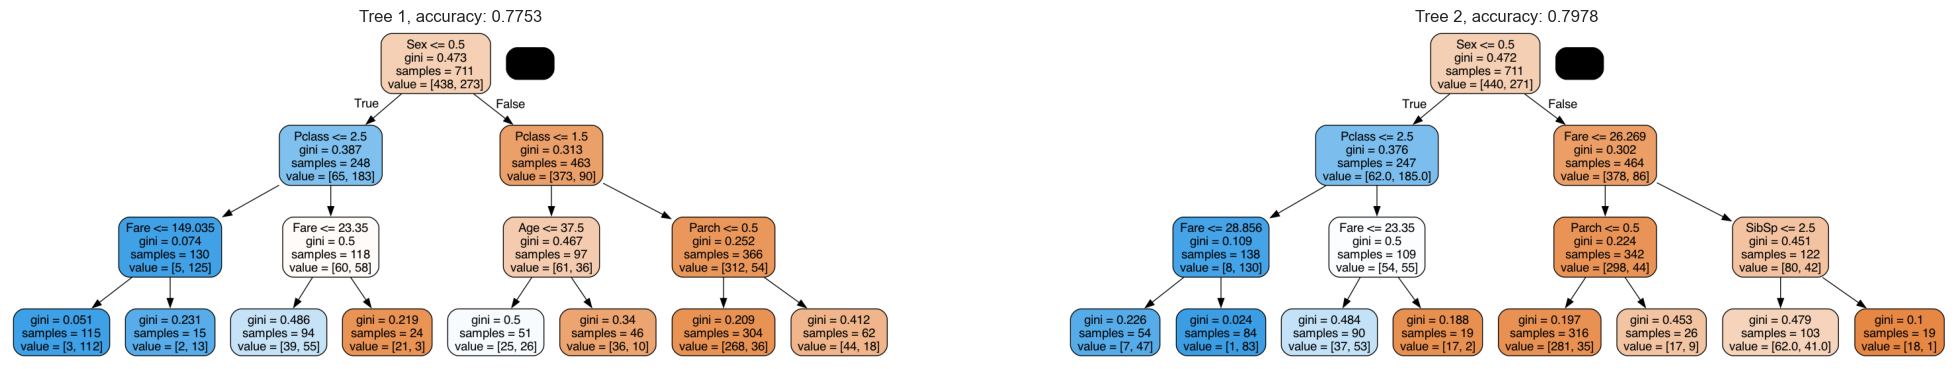

Accuracy for the first tree: 0.7753
Accuracy for the second tree: 0.7978


In [11]:
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1, accuracy: {tree1_accuracy:.4f}')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X_2)
plt.axis('off')
plt.title(f'Tree 2, accuracy: {tree2_accuracy:.4f}')
plt.show()
print(f'Accuracy for the first tree: {tree1_accuracy:.4f}')
print(f'Accuracy for the second tree: {tree2_accuracy:.4f}')

Мы отправили в тест лишь 20% данных, а деревья получились очень разными! 

И при увеличении глубины дерева становится только хуже.

## Bagging
Вместо того, чтобы обучить одно дерево решений, обучим ансамбль по следующему алгоритму:

1. Сгенерируем $B$ бутсрэп выборок (сэмплирование с возвращением, помните?) из обучающего набора данных.
2. Обучим $B$ решающих деревьев $f_1, f_2, \dots, f_B$ на каждой из бутсреп подвыборок.
3. В качестве предсказания на тестовых данных возьмем среднее предсказание алгорима $\hat{y} = 1/B \sum_{i=0}^{B} f_i(x)$ (для задачи классификации возьмем наиболее популярный класс).


In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
from sklearn.ensemble import BaggingClassifier

In [15]:
# BaggingRegressor can be used with any model, not only decision trees

model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1, n_estimators=100)
model.fit(train_X, train_Y)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                  n_estimators=100, n_jobs=-1)

In [16]:
print(f'Bagged trees accuracy score {accuracy_score(model.predict(test_X), test_Y):.4f}')


Bagged trees accuracy score 0.8090


Можем посмотреть на отдельные деревья.

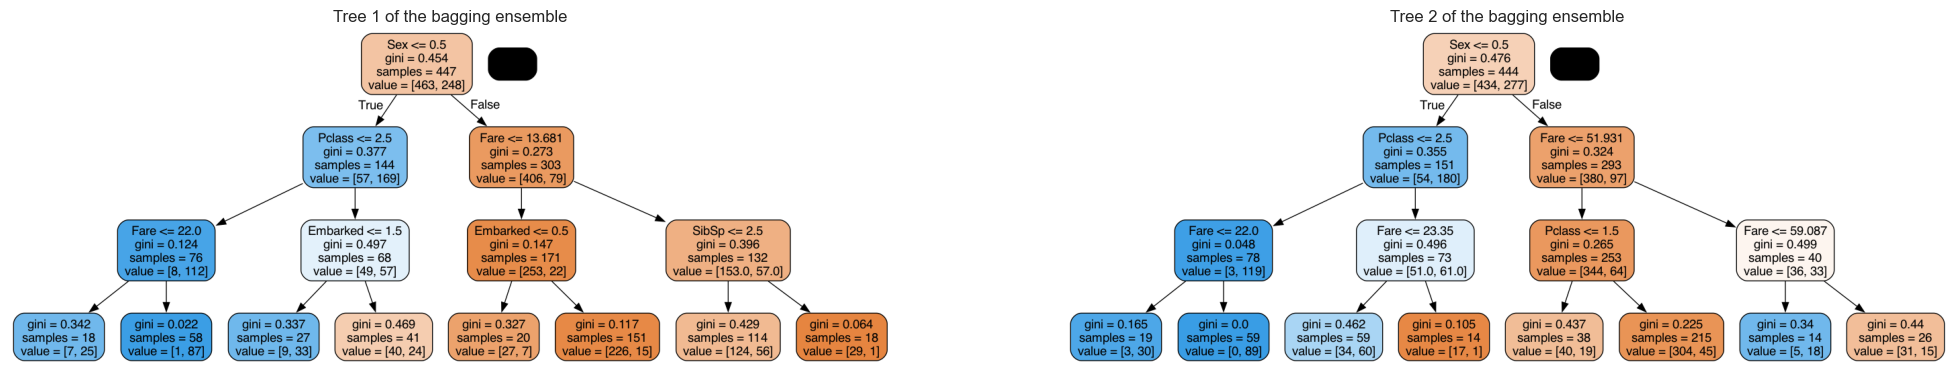

In [17]:
tree1, tree2 = model.estimators_[0], model.estimators_[50]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1 of the bagging ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the bagging ensemble')
plt.show()

Процесс обучения бэггинг ансамбля позволяет оценивать тестовую ошибку без кросс-валидации. Вспомним, что каждое дерево обучается на помножестве train'овых данных. 

#### Out-of-bag score
Мы можем использовать трейновую выборку для предсказаний. Для каждого примера $x_i$ сделаем предсказания с использованием тех деревьев, которые не использовали $x_i$ при обучении. Затем усредним предсказания и посчитаем ошибку. Получим робастную оценку тестовой ошибки. 

In [18]:
# обучим без ограничения максимальной глубины max_depth=None и с oob_score=True
model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_jobs=-1, n_estimators=20, oob_score=True)
model.fit(train_X, train_Y)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True)

In [19]:
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Test score estimate using Cross-Validation {cross_val_score(model, train_X, train_Y, scoring="accuracy").mean():.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Test score estimate using Out-of-bag score 0.8186
Test score estimate using Cross-Validation 0.8200
Actual test score: 0.7809


## Not only trees...

In [20]:
from sklearn.linear_model import LogisticRegression

In [22]:
clf1 = LogisticRegression(random_state=1)
clf1.fit(train_X, train_Y)
clf1_accuracy = accuracy_score(tree1.predict(test_X), test_Y)
print(f'Accuracy for the clf1: {clf1_accuracy:.4f}')

model = BaggingClassifier(estimator=LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000), n_jobs=-1, n_estimators=100)
model.fit(train_X, train_Y)
model_accuracy = accuracy_score(model.predict(test_X), test_Y)
print(f'Accuracy for the model: {model_accuracy:.4f}')

Accuracy for the clf1: 0.8034
Accuracy for the model: 0.7809


## Скрестим ужа и ежа

In [23]:
from sklearn.ensemble import VotingClassifier

In [24]:
clf1 = LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000)
clf2 = DecisionTreeClassifier(max_depth=3, random_state=1)

blending_classifier = VotingClassifier(
    estimators=[("log_regrassion", clf1), ("random_forest", clf2)] 
)

blending_classifier.fit(train_X, train_Y)
y_pred = blending_classifier.predict(test_X)
blending_accuracy = accuracy_score(test_Y, y_pred)
print(f'Accuracy for the VotingClassifier: {blending_accuracy:.4f}')

blending_classifier

Accuracy for the VotingClassifier: 0.7978


VotingClassifier(estimators=[('log_regrassion',
                              LogisticRegression(max_iter=1000,
                                                 random_state=1)),
                             ('random_forest',
                              DecisionTreeClassifier(max_depth=3,
                                                     random_state=1))])

### и соберем Франкенштейна

In [26]:
model1 = BaggingClassifier(estimator=LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000), n_jobs=-1, n_estimators=100)
model2 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_jobs=-1, n_estimators=20, oob_score=True)

blending_classifier = VotingClassifier(
    estimators=[("LogisticRegression", model1), 
                ("DecisionTreeClassifier", model2)] 
)

blending_classifier.fit(train_X, train_Y)
y_pred = blending_classifier.predict(test_X)
blending_accuracy = accuracy_score(test_Y, y_pred)
print(f'Accuracy for the VotingClassifier: {blending_accuracy:.4f}')

blending_classifier

Accuracy for the VotingClassifier: 0.8034


VotingClassifier(estimators=[('LogisticRegression',
                              BaggingClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                             random_state=1),
                                                n_estimators=100, n_jobs=-1)),
                             ('DecisionTreeClassifier',
                              BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                n_estimators=20, n_jobs=-1,
                                                oob_score=True))])

## Random Forests
Деревья в бэггинг ансамблях зачастую сильно **коррелируют** между собой. Они очень похожи, так как обучаются на похожих выборках. Когда мы агрегируем предсказания похожих деревьев, мы не так сильно уменьшаем разброс (variance), как нам бы хотелось.

Как уменьшить корреляцию деревьев?

**Solution: Random Forest!** Построим ансамбль деревьев определенным образом. Каждый раз, когда будем выбирать сплит при обучении, будем перебирать только $m$ случайно выбранных признаков из $p$, при этом $m < p$. _Хорошая эвристика использовать_ $m = \sqrt{p}$

In [27]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 3, oob_score=True)
model.fit(train_X, train_Y)

RandomForestClassifier(max_depth=3, n_jobs=-1, oob_score=True)

In [28]:
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Test score estimate using Out-of-bag score 0.7848
Actual test score: 0.8090


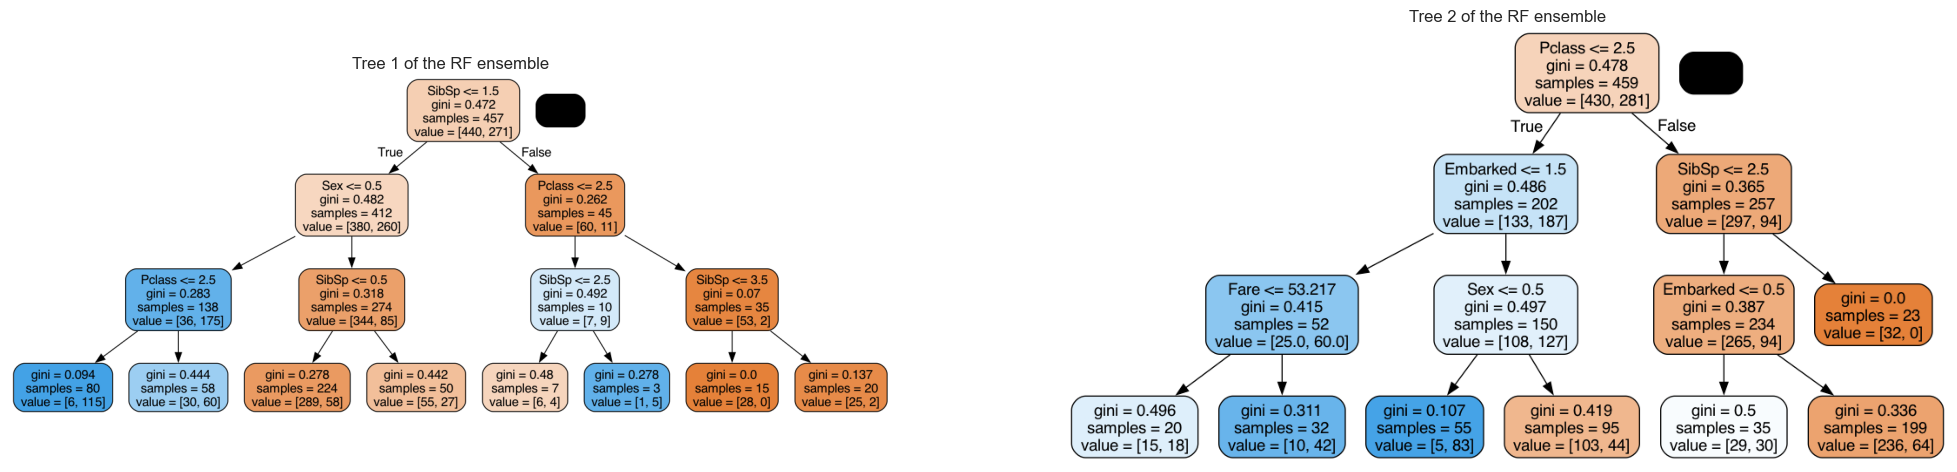

In [29]:
tree1, tree2 = model.estimators_[0], model.estimators_[30]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1 of the RF ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the RF ensemble')
plt.show()

In [30]:
# Now lets try realistic max_depth
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = None, oob_score=True)
model.fit(train_X, train_Y)
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Test score estimate using Out-of-bag score 0.8214
Actual test score: 0.7753


## Посмотрим на подбор параметров

In [31]:
model = RandomForestClassifier(random_state=1)

parameters = {'n_estimators': [10, 20, 50, 70],
            'max_depth':[1, 3, 5, 7, 10, 12, 15, 20],
            'min_samples_split' : [2, 5, 10, 20],
            'min_samples_leaf':[1, 5]}

gs = GridSearchCV(model,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=5)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(train_X, train_Y)
print(gs.best_params_)
print(f'Test score: {accuracy_score(gs.predict(test_X), test_Y):.4f}')

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Test score: 0.7809


## Важность признаков (feature importance)

Для каждого дерева, для признака можно посчитать прирост информации (information gain), полученный при разбиении по этому признаку. Это и есть мера важности признака.



In [32]:
feature_importances = zip(train_X.columns, gs.best_estimator_.feature_importances_)
list(feature_importances)

[('Pclass', 0.10775093087447758),
 ('Sex', 0.33325436579697004),
 ('Age', 0.16307645834188575),
 ('SibSp', 0.05793651129092266),
 ('Parch', 0.05134145425979709),
 ('Fare', 0.24369800667662575),
 ('Embarked', 0.04294227275932115)]

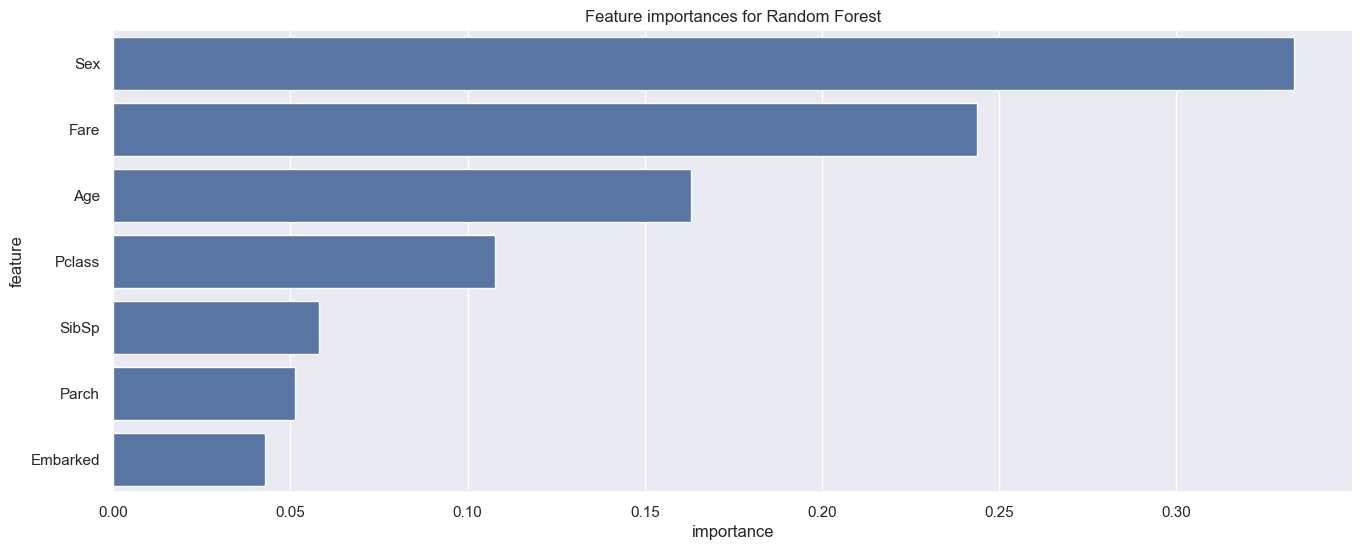

In [33]:
feature_importances = zip(train_X.columns, gs.best_estimator_.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

## Tuning

Основные фичи, которые можно тюнить:
* `n_estimators` - число деревьев,
* `max_samples` - число сэмплов в бутсреп выборке,
* `max_features` - число признаков, которое рассматривается при разбиении,
* `max_depth` - максимальная глубина дерева.


Больше информации можно найти [тут](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/).

In [34]:
%%time
parameters = {'n_estimators': [5, 10, 50, 100, 500], 
            'max_features' : [None, 3], 
            'max_depth':[None, 3, 5, 10]}

model = RandomForestClassifier()
clf = GridSearchCV(model, parameters, scoring = 'accuracy')

clf.fit(train_X, train_Y)
pred = clf.predict(test_X)


print('Best parameters: ', clf.best_params_)
print(f'Test score: {accuracy_score(pred, test_Y):.4f}')

Best parameters:  {'max_depth': 10, 'max_features': None, 'n_estimators': 10}
Test score: 0.7865
CPU times: user 15 s, sys: 257 ms, total: 15.3 s
Wall time: 15.3 s


In [35]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 3, oob_score=False)
model.fit(train_X, train_Y)
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Actual test score: 0.7978


# Stacking

In [36]:
from sklearn.ensemble import StackingClassifier

In [37]:
clf1 = LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000)
clf2 = DecisionTreeClassifier(max_depth=3, random_state=1)

estimators = [
    ("LogisticRegression", clf1),
    ("DecisionTreeClassifier", clf2)
    ]

# построим классификатор используя стекинг и наш список классификаторов
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, solver='lbfgs', max_iter=1000),
    n_jobs=-1,
    verbose=True,
)

stacking_classifier.fit(train_X, train_Y)
y_pred = stacking_classifier.predict(test_X)
stacking_accuracy = accuracy_score(test_Y, y_pred)

print(f'Accuracy for the StackingClassifier: {stacking_accuracy:.4f}')

Accuracy for the StackingClassifier: 0.8146


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [87]:
stacking_classifier

StackingClassifier(estimators=[('LogisticRegression',
                                LogisticRegression(max_iter=1000,
                                                   random_state=1)),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier(max_depth=3,
                                                       random_state=1))],
                   final_estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
                   n_jobs=-1, verbose=True)

In [38]:
model1 = BaggingClassifier(estimator=LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000), n_jobs=-1, n_estimators=100)
model2 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_jobs=-1, n_estimators=20, oob_score=True)
model3 = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 3, oob_score=True)

estimators = [
    ("LogisticRegression", model1),
    ("DecisionTreeClassifier", model2),
    ("RandomForestClassifier", model3),
    ]

# построим классификатор используя стекинг и наш список классификаторов
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, solver='lbfgs', max_iter=1000),
    n_jobs=-1,
    verbose=False,
)

stacking_classifier.fit(train_X, train_Y)
y_pred = stacking_classifier.predict(test_X)
stacking_accuracy = accuracy_score(test_Y, y_pred)

print(f'Accuracy for the StackingClassifier: {stacking_accuracy:.4f}')

Accuracy for the StackingClassifier: 0.7978


In [39]:
stacking_classifier

StackingClassifier(estimators=[('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                               random_state=1),
                                                  n_estimators=100,
                                                  n_jobs=-1)),
                               ('DecisionTreeClassifier',
                                BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                  n_estimators=20, n_jobs=-1,
                                                  oob_score=True)),
                               ('RandomForestClassifier',
                                RandomForestClassifier(max_depth=3, n_jobs=-1,
                                                       oob_score=True))],
                   final_estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
                   n_jobs=-1, verbose=False)